In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer

from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN

from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

import joblib
import pickle


import warnings
warnings.filterwarnings('ignore')


In [2]:
# read the dataset
df = pd.read_csv('Data.csv')
df.head()

,user_id,REGION,TENURE,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,TIGO,ZONE1,ZONE2,MRG,REGULARITY,TOP_PACK,FREQ_TOP_PACK,CHURN
0,dcf68cc2fb515ccad7d8b9b3bd80ee2a4b270063,SAINT-LOUIS,K > 24 month,17000.0,32.0,18000.0,6000.0,34.0,NaN,97.0,355.0,6.0,NaN,NaN,NO,62,All-net 500F=2000F;5d,35.0,0
1,71c44b5ba328db5c4192a80f7cf8f244d9350ed0,NaN,K > 24 month,4300.0,29.0,4427.0,1476.0,37.0,1764.0,8.0,3.0,0.0,NaN,2.0,NO,40,"Data: 100 F=40MB,24H",22.0,0
2,ce46411b1526c94f20a383b8cb188f8d27f82a0a,TAMBACOUNDA,K > 24 month,1500.0,3.0,1500.0,500.0,3.0,NaN,30.0,30.0,NaN,NaN,NaN,NO,32,All-net 500F=2000F;5d,3.0,0
3,f467cdb6669818373c26c2bad44e01ba66f97d21,FATICK,K > 24 month,1500.0,3.0,2497.0,832.0,4.0,0.0,159.0,45.0,19.0,NaN,NaN,NO,18,On net 200F=Unlimited _call24H,3.0,0
4,ec45e1a1888a32b5dcce0954cfec20c6e037db31,FATICK,K > 24 month,NaN,NaN,498.0,166.0,3.0,1.0,1.0,3.0,NaN,NaN,NaN,NO,50,NaN,NaN,0


In [3]:
# data info
df.shape

(400000, 19)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400000 entries, 0 to 399999
Data columns (total 19 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   user_id         400000 non-null  object 
 1   REGION          242480 non-null  object 
 2   TENURE          400000 non-null  object 
 3   MONTANT         259723 non-null  float64
 4   FREQUENCE_RECH  259723 non-null  float64
 5   REVENUE         265337 non-null  float64
 6   ARPU_SEGMENT    265337 non-null  float64
 7   FREQUENCE       265337 non-null  float64
 8   DATA_VOLUME     203146 non-null  float64
 9   ON_NET          254181 non-null  float64
 10  ORANGE          233683 non-null  float64
 11  TIGO            160614 non-null  float64
 12  ZONE1           31690 non-null   float64
 13  ZONE2           25513 non-null   float64
 14  MRG             400000 non-null  object 
 15  REGULARITY      400000 non-null  int64  
 16  TOP_PACK        232671 non-null  object 
 17  FREQ_TOP_P

In [86]:
# check missing values
df.isna().sum()

user_id                0
REGION            157520
TENURE                 0
MONTANT           140277
FREQUENCE_RECH    140277
REVENUE           134663
ARPU_SEGMENT      134663
FREQUENCE         134663
DATA_VOLUME       196854
ON_NET            145819
ORANGE            166317
TIGO              239386
ZONE1             368310
ZONE2             374487
MRG                    0
REGULARITY             0
TOP_PACK          167329
FREQ_TOP_PACK     167329
CHURN                  0
dtype: int64

In [3]:
# drop columns of no effect/use: user_id, tigo, zone1, zone2 columns
df = df.drop(columns=['user_id', 'TIGO', 'ZONE1', 'ZONE2'], axis=1)
df.columns

Index(['REGION', 'TENURE', 'MONTANT', 'FREQUENCE_RECH', 'REVENUE',
       'ARPU_SEGMENT', 'FREQUENCE', 'DATA_VOLUME', 'ON_NET', 'ORANGE', 'MRG',
       'REGULARITY', 'TOP_PACK', 'FREQ_TOP_PACK', 'CHURN'],
      dtype='object')

 Distribution of numerical columns: ['MONTANT', 'FREQUENCE_RECH', 'REVENUE', 'ARPU_SEGMENT', 'FREQUENCE', 'DATA_VOLUME', 'ON_NET', 'ORANGE', 'TIGO', 'ZONE1', 'ZONE2', 'REGULARITY', 'FREQ_TOP_PACK', 'CHURN']


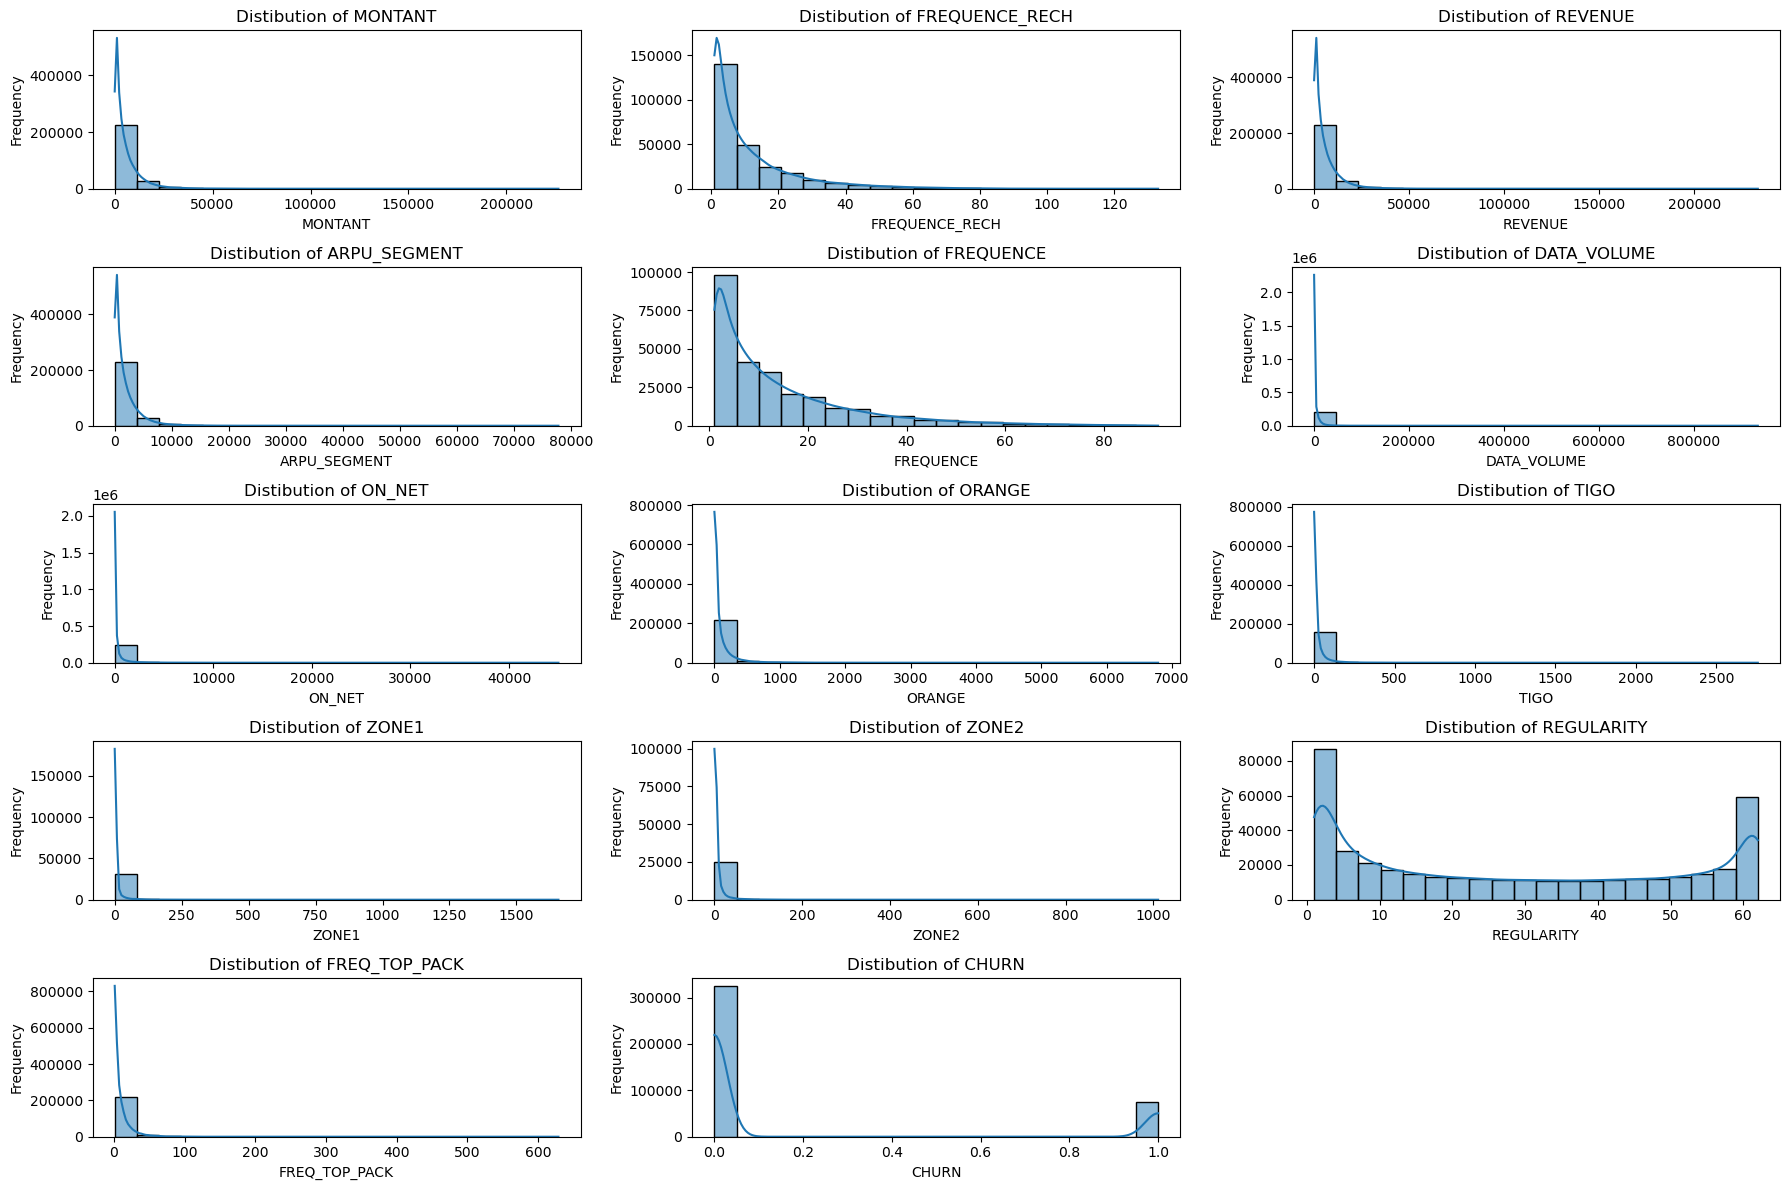

In [62]:
# distribution of numerical features
numerical_columns = df.select_dtypes(include=['float', 'int']).columns.tolist()
print(" Distribution of numerical columns:", numerical_columns)

# create the figure
plt.figure(figsize=(18,12))

for i, column in enumerate(numerical_columns, 1):
    plt.subplot(5, 3, i)
    sns.histplot(df[column], kde=True, bins=20)
    plt.title(f'Distibution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

Most numerical features seem to be positively skewed. We may have to impute missing values with the median

In [63]:
# checking skewness of numerical features'
for col in numerical_columns:
    if df[col].dtype != 'object':  # Ensure the column is numeric
        skewness = df[col].skew()
        print(f'Skewness of {col}: {skewness}')

Skewness of MONTANT: 3.914305271429013
Skewness of FREQUENCE_RECH: 2.122098489316664
Skewness of REVENUE: 3.684768239977562
Skewness of ARPU_SEGMENT: 3.684780656504547
Skewness of FREQUENCE: 1.7761786985633876
Skewness of DATA_VOLUME: 27.72722777192043
Skewness of ON_NET: 8.513781421430073
Skewness of ORANGE: 7.225839202497203
Skewness of TIGO: 11.539106874021275
Skewness of ZONE1: 15.98540174778884
Skewness of ZONE2: 14.310807111054798
Skewness of REGULARITY: 0.2479780763118966
Skewness of FREQ_TOP_PACK: 4.205883937750843
Skewness of CHURN: 1.604570921993981


### A. Preprocessing steps (keeping outliers)

#### Data Splitting

In [4]:
# defining features and targets:
X = df.drop('CHURN', axis=1)
y = df['CHURN']

In [5]:
# split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
X_train.head()

,REGION,TENURE,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,MRG,REGULARITY,TOP_PACK,FREQ_TOP_PACK
242245,SAINT-LOUIS,K > 24 month,26500.0,40.0,25721.0,8574.0,44.0,0.0,1517.0,33.0,NO,62,"On-net 500=4000,10d",39.0
288918,DAKAR,K > 24 month,500.0,1.0,520.0,173.0,2.0,1202.0,0.0,NaN,NO,36,NaN,NaN
105103,DAKAR,K > 24 month,7000.0,13.0,8151.0,2717.0,19.0,0.0,24.0,109.0,NO,59,All-net 500F=2000F;5d,5.0
63504,DIOURBEL,K > 24 month,9100.0,29.0,8845.0,2948.0,32.0,2595.0,393.0,37.0,NO,49,Mixt 250F=Unlimited_call24H,9.0
239180,DAKAR,K > 24 month,4750.0,9.0,4751.0,1584.0,12.0,4081.0,8.0,53.0,NO,47,All-net 500F=2000F;5d,3.0


In [7]:
X_test.head()

,REGION,TENURE,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,MRG,REGULARITY,TOP_PACK,FREQ_TOP_PACK
23218,SAINT-LOUIS,K > 24 month,900.0,3.0,888.0,296.0,3.0,1.0,NaN,18.0,NO,33,All-net 500F=2000F;5d,1.0
20731,LOUGA,K > 24 month,2950.0,6.0,2651.0,884.0,7.0,0.0,111.0,NaN,NO,44,All-net 500F =2000F_AllNet_Unlimited,4.0
39555,NaN,K > 24 month,4550.0,21.0,5006.0,1669.0,24.0,NaN,1207.0,114.0,NO,33,On net 200F=Unlimited _call24H,16.0
147506,TAMBACOUNDA,K > 24 month,4000.0,4.0,4000.0,1333.0,4.0,NaN,240.0,NaN,NO,47,On-net 1000F=10MilF;10d,4.0
314215,NaN,K > 24 month,2000.0,2.0,1980.0,660.0,2.0,3682.0,NaN,NaN,NO,2,"Data:1000F=2GB,30d",2.0


train_test_split is done before all preprocessing to prevent data leakage which ensures the integrity of the machine learning model built

In [8]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 320000 entries, 242245 to 121958
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   REGION          193895 non-null  object 
 1   TENURE          320000 non-null  object 
 2   MONTANT         207691 non-null  float64
 3   FREQUENCE_RECH  207691 non-null  float64
 4   REVENUE         212147 non-null  float64
 5   ARPU_SEGMENT    212147 non-null  float64
 6   FREQUENCE       212147 non-null  float64
 7   DATA_VOLUME     162419 non-null  float64
 8   ON_NET          203301 non-null  float64
 9   ORANGE          186769 non-null  float64
 10  MRG             320000 non-null  object 
 11  REGULARITY      320000 non-null  int64  
 12  TOP_PACK        186083 non-null  object 
 13  FREQ_TOP_PACK   186083 non-null  float64
dtypes: float64(9), int64(1), object(4)
memory usage: 36.6+ MB


### Handling Missing Values

In [6]:
# impute numerical columns with median
numerical_cols = X_train.select_dtypes(include=['float', 'int']).columns

median_imputer = SimpleImputer(strategy='median')
# fit imputer on training data
median_imputer.fit(X_train[numerical_cols])

# transform the training and test data
X_train[numerical_cols] = median_imputer.transform(X_train[numerical_cols])
X_test[numerical_cols] = median_imputer.transform(X_test[numerical_cols])

In [7]:
# impute categorical columns with mode(mos frequent)

categorical_cols = X_train.select_dtypes(include=['object']).columns

mode_imputer = SimpleImputer(strategy='most_frequent')
# fit on the training data
mode_imputer.fit(X_train[categorical_cols])

# transform the train and test data
X_train[categorical_cols] = mode_imputer.transform(X_train[categorical_cols])
X_test[categorical_cols] = mode_imputer.transform(X_test[categorical_cols])

#### Label Encoding

Aim here is to apply the same label encoder to both the train and test set!

In [8]:
# functoin to perform label encoding
def fit_and_transform(le, train_data, test_data):
    # fit encoder on the train data
    le.fit(train_data)
    # Transform train data
    train_transformed = le.transform(train_data)
    
    # Transform test data, handling unseen labels if any
    test_transformed = np.array([le.transform([val])[0] if val in le.classes_ else -1 for val in test_data])
    
    return train_transformed, test_transformed

In [9]:
for col in X_train.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X_train[col], X_test[col] = fit_and_transform(le, X_train[col], X_test[col])

In [13]:
X_test.head()

,REGION,TENURE,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,MRG,REGULARITY,TOP_PACK,FREQ_TOP_PACK
23218,9,7,900.0,3.0,888.0,296.0,3.0,1.0,26.0,18.0,0,33.0,14,1.0
20731,7,7,2950.0,6.0,2651.0,884.0,7.0,0.0,111.0,29.0,0,44.0,12,4.0
39555,0,7,4550.0,21.0,5006.0,1669.0,24.0,265.0,1207.0,114.0,0,33.0,82,16.0
147506,11,7,4000.0,4.0,4000.0,1333.0,4.0,265.0,240.0,29.0,0,47.0,83,4.0
314215,0,7,2000.0,2.0,1980.0,660.0,2.0,3682.0,26.0,29.0,0,2.0,28,2.0


In [14]:
X_train.head()

,REGION,TENURE,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,MRG,REGULARITY,TOP_PACK,FREQ_TOP_PACK
242245,9,7,26500.0,40.0,25721.0,8574.0,44.0,0.0,1517.0,33.0,0,62.0,87,39.0
288918,0,7,500.0,1.0,520.0,173.0,2.0,1202.0,0.0,29.0,0,36.0,14,5.0
105103,0,7,7000.0,13.0,8151.0,2717.0,19.0,0.0,24.0,109.0,0,59.0,14,5.0
63504,1,7,9100.0,29.0,8845.0,2948.0,32.0,2595.0,393.0,37.0,0,49.0,76,9.0
239180,0,7,4750.0,9.0,4751.0,1584.0,12.0,4081.0,8.0,53.0,0,47.0,14,3.0


### Scaling/Normalization

In [10]:
scaler = StandardScaler()

# fit and transform the train set
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)

# transform the test set
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [16]:
X_train_scaled

,REGION,TENURE,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,MRG,REGULARITY,TOP_PACK,FREQ_TOP_PACK
0,1.446954,0.211228,3.750993,2.763247,3.542506,3.542679,2.605464,-0.205477,1.877571,-0.218588,0.0,1.524976,2.089046,3.299194
1,-0.644102,0.211228,-0.709016,-0.777844,-0.695966,-0.696137,-0.844057,-0.071606,-0.260720,-0.243573,0.0,0.357957,-0.657168,-0.258905
2,-0.644102,0.211228,0.405986,0.311722,0.587466,0.587466,0.552178,-0.205477,-0.226891,0.256140,0.0,1.390320,-0.657168,-0.258905
3,-0.411762,0.211228,0.766218,1.764478,0.704188,0.704019,1.619887,0.083537,0.293234,-0.193602,0.0,0.941467,1.675233,0.159695
4,-0.644102,0.211228,0.020024,-0.051467,0.015632,0.015798,-0.022742,0.249038,-0.249444,-0.093659,0.0,0.851696,-0.657168,-0.468205
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319995,-0.411762,0.211228,-0.623247,-0.687047,-0.615236,-0.615407,-0.844057,-0.103682,-0.046468,-0.412226,0.0,0.043760,-0.657168,-0.677505
319996,1.446954,0.211228,0.491756,0.493317,0.562070,0.562238,0.305784,-0.205477,-0.190243,0.406054,0.0,1.524976,-0.657168,0.892245
319997,1.911633,0.211228,-0.760478,-0.777844,-0.755504,-0.755675,-0.844057,-0.179527,-0.250853,-0.418473,0.0,-1.078374,-0.657168,-0.258905
319998,0.982275,0.211228,-0.365938,-0.414656,-0.362956,-0.363127,-0.597662,-0.175963,-0.135270,-0.031195,0.0,0.986352,-0.657168,-0.363555


### Model Training (Logistic Regression)

In [20]:
y_test

23218     0
20731     0
39555     0
147506    0
314215    1
         ..
54840     1
103       0
339434    1
315677    0
164567    0
Name: CHURN, Length: 80000, dtype: int64

In [21]:
lr_model = LogisticRegression(random_state=42)
lr_model.fit(X_train_scaled, y_train)

# make predictions
predictions = lr_model.predict(X_test_scaled)

# model evaluation
lr_model_accuracy = accuracy_score(y_test, predictions)
report = classification_report(y_test, predictions)

print(f"Logistic Regression accuracy: {lr_model_accuracy}")
print(f"Classification report: \n {report}")

Logistic Regression accuracy: 0.8647
Classification report: 
               precision    recall  f1-score   support

           0       0.92      0.91      0.92     65023
           1       0.63      0.66      0.65     14977

    accuracy                           0.86     80000
   macro avg       0.78      0.78      0.78     80000
weighted avg       0.87      0.86      0.87     80000



### Preprocessing B  
- select best features
- apply smote to take care of imbalance  
- use PCA to reduce dimension of data

In [26]:
# Initialize and apply SelectKBest
selector = SelectKBest(f_classif, k=5)  #select the best five features
X_train_selected = selector.fit_transform(X_train_scaled, y_train)
X_test_selected = selector.transform(X_test_scaled)

In [27]:
# use smote to handle imbalance
smote = SMOTE(random_state=42)

# Apply SMOTE to the training data
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_selected, y_train)

In [36]:
# Initialize PCA and fit on the resampled training data
pca = PCA(n_components=5)  
X_train_pca = pca.fit_transform(X_train_resampled)
X_test_pca = pca.transform(X_test_selected)

In [37]:
# Train the logistic regression model on the PCA-transformed training data
lr_model2 = LogisticRegression(max_iter=1000, random_state=42)
lr_model2.fit(X_train_pca, y_train_resampled)

# Make predictions on the PCA-transformed test data
predictions2 = lr_model2.predict(X_test_pca)

# Model evaluation
lr_model2_accuracy = accuracy_score(y_test, predictions2)
report2 = classification_report(y_test, predictions2)

print(f"Logistic Regression accuracy: {lr_model2_accuracy}")
print(f"Classification report: \n {report2}")

Logistic Regression accuracy: 0.78995
Classification report: 
               precision    recall  f1-score   support

           0       0.97      0.77      0.86     65023
           1       0.47      0.89      0.61     14977

    accuracy                           0.79     80000
   macro avg       0.72      0.83      0.74     80000
weighted avg       0.88      0.79      0.81     80000



### Preprocing with Smote alone  
- use scaled train set

In [11]:
# apply smote on train set to deal with target imbabalance
smote = SMOTEENN(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

print("Original training set target distribution: ", y_train.value_counts())
print("resampled training set targets distribution: ", y_train_smote.value_counts())

Original training set target distribution:  CHURN
0    260133
1     59867
Name: count, dtype: int64
resampled training set targets distribution:  CHURN
0    194711
1    146753
Name: count, dtype: int64


In [12]:
# train model with smoted/resampled train data
mdl = LogisticRegression(random_state=42)

# fit the model
mdl.fit(X_train_smote, y_train_smote)

# make predictions
preds = mdl.predict(X_test_scaled)

# Model evaluation
mdl_accuracy = accuracy_score(y_test, preds)
smoted_report = classification_report(y_test, preds)

print(f"Logistic Regression accuracy: {mdl_accuracy}")
print(f"Classification report: \n {smoted_report}")

Logistic Regression accuracy: 0.7824
Classification report: 
               precision    recall  f1-score   support

           0       0.97      0.75      0.85     65023
           1       0.46      0.90      0.61     14977

    accuracy                           0.78     80000
   macro avg       0.71      0.83      0.73     80000
weighted avg       0.88      0.78      0.80     80000



### Preprocessing C - Removed Outliers

In [ ]:
# set the quantiles
Q1_train = X_train_scaled.quantile(0.25)
Q3_train = X_train_scaled.quantile(0.75)
IQR_train = Q3_train - Q1_train

threshold = 1.5
train_outliers = ((X_train_scaled < (Q1_train - threshold * IQR_train)) | 
                  (X_train_scaled > (Q3_train + threshold * IQR_train))).any(axis=1)

# Remove outliers from training set
X_train_no_outliers = X_train_scaled[~train_outliers]
y_train_no_outliers = y_train[~train_outliers]

# Apply the same outlier removal criteria to the test set
outliers_test = ((X_test_scaled < (Q1_train - threshold * IQR_train)) | 
                 (X_test_scaled > (Q3_train + threshold * IQR_train))).any(axis=1)



In [1]:
df.ead()

NameError: name 'df' is not defined